In [1]:
import pickle, glob, os, blosc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from time import sleep
from datetime import datetime, date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, OrthogonalMatchingPursuit, Lars, LassoLarsCV
from sklearn.linear_model import Ridge, LassoLars, ARDRegression, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.svm import LinearSVR

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern 
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, DotProduct


path_to_pds = r"/Users/Guille/Desktop/caiso_power/output/processed_data/"
path_to_aux = r"/Users/Guille/Desktop/caiso_power/output/auxiliary/"
path_to_images = r"/Users/Guille/Desktop/caiso_power/images/"

# Get Grid Dimensions
N = 104
M = 88

In [2]:
# Load data in a compressed file
def _load_data_in_chunks(years_, path):
    # Open a BLOSC compressed file
    def __load_data_in_compressed_file(file):
        with open(file, "rb") as f:
            data_ = f.read()
        return pickle.loads(blosc.decompress(data_)) 
    # Loop over processed years
    data_ = []
    for year in years_:
        # Find processed data from that year
        files_ = glob.glob(path + "{}_*".format(year))
        # Define the maximum feasible number of chunks
        N_min_chunks = len(files_)
        # Loop over all possible chunks
        for i in range(N_min_chunks):
            V_, W_, X_, Y_, Z_ = [], [], [], [], []
            for j in range(N_min_chunks):
                # Load data if extis
                try:
                    file_name = path + "{}_{}-{}.dat".format(year, i, j)
                    data_p_   = __load_data_in_compressed_file(file_name)
                    # Append together all chucks
                    V_.append(data_p_[0])
                    W_.append(data_p_[1])
                    X_.append(data_p_[2])
                    Y_.append(data_p_[3])
                    Z_.append(data_p_[4])
                    print(file_name)
                except: 
                    continue  
            # Concatenate data if files existed
            if len(X_) > 0:
                V_ = np.concatenate(V_, axis = 0)
                W_ = np.concatenate(W_, axis = 0)
                X_ = np.concatenate(X_, axis = 0)
                Y_ = np.concatenate(Y_, axis = 0)
                Z_ = np.concatenate(Z_, axis = 0)
                data_.append([V_, W_, X_, Y_, Z_])
    return data_

# Process all chunks of data to form a dataset with a given strcuture
def _structure_dataset(data_, i_resource, i_asset, v_idx_ = None, 
                                                   w_idx_ = None,
                                                   x_idx_ = None,
                                                   y_idx_ = None,
                                                   z_idx_ = None,
                                                   D_idx_ = None):
    v_idx_ = v_idx_[i_resource]
    w_idx_ = w_idx_[i_resource]
    x_idx_ = x_idx_[i_resource]
    y_idx_ = y_idx_[i_resource]
    z_idx_ = z_idx_[i_resource]
    # Concatenate all chucks of data in matrix form
    V_, W_, X_, Y_, Z_ = [], [], [], [], []
    for i in range(len(data_)):
        V_.append(data_[i][0][:, v_idx_])
        W_.append(data_[i][1][:, w_idx_])
        X_.append(data_[i][2][:, x_idx_, :])
        Y_.append(data_[i][3][:, y_idx_, :])
        Z_.append(data_[i][4][:, z_idx_])  
    V_ = np.concatenate(V_, axis = 0)
    W_ = np.concatenate(W_, axis = 0)
    X_ = np.concatenate(X_, axis = 0)
    Y_ = np.concatenate(Y_, axis = 0)
    Z_ = np.concatenate(Z_, axis = 0)
    print(V_.shape, W_.shape, X_.shape, Y_.shape, Z_.shape)
    # Apply features selection heuristic
    V_p_ = V_[:, i_asset]
    W_p_ = W_[:, i_asset]
    X_p_ = X_[..., D_idx_ > 0.]
    Y_p_ = Y_[..., D_idx_ > 0.]
    del V_, W_, X_, Y_
    # Concatenate all the dimensions
    X_pp_, Y_pp_ = [], []
    for d in range(X_p_.shape[1]):
        X_pp_.append(X_p_[:, d, :])
        Y_pp_.append(Y_p_[:, d, :])
    X_pp_ = np.concatenate(X_pp_, axis = -1)
    Y_pp_ = np.concatenate(Y_pp_, axis = -1)
    print(X_pp_.shape, Y_pp_.shape)
    del X_p_, Y_p_
    # Concatenate by hours
    V_pp_, W_pp_, X_ppp_, Y_ppp_, Z_p_ = [], [], [], [], []
    for n in range(int(V_p_.shape[0]/24)):
        k = n*24
        l = (n + 1)*24
        V_pp_.append(V_p_[k:l, ...][:,np.newaxis])
        W_pp_.append(W_p_[k:l, ...][:, np.newaxis])
        X_ppp_.append(X_pp_[k:l, ...][:, np.newaxis, :])
        Y_ppp_.append(Y_pp_[k:l, ...][:, np.newaxis, :])
        Z_p_.append(Z_[k:l, ...][:, np.newaxis, :])
    V_pp_  = np.concatenate(V_pp_, axis = 1)
    W_pp_  = np.concatenate(W_pp_, axis = 1)
    X_ppp_ = np.concatenate(X_ppp_, axis = 1)
    Y_ppp_ = np.concatenate(Y_ppp_, axis = 1)
    Z_p_   = np.concatenate(Z_p_, axis = 1)
    del W_p_, Y_pp_, Z_
    return V_pp_, W_pp_, X_ppp_, Y_ppp_, Z_p_
    #return V_pp_, V_p_, X_pp_, Y_ppp_, Z_p_

In [3]:
i_resource = 1
i_asset    = 0

# Load the index of US land in the NOAA operational forecast
US_land_ = pd.read_pickle(path_to_aux + r"USland_0.125_(-125,-112)_(32,43).pkl")
US_land_ = np.ones(US_land_.shape)

# Load propossed data
data_ = _load_data_in_chunks([2022], path_to_pds)
print(len(data_))

/Users/Guille/Desktop/caiso_power/output/processed_data/2022_0-0.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_0-1.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_1-0.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_1-1.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_1-2.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_2-0.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_2-1.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_2-2.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_3-0.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_4-0.dat
/Users/Guille/Desktop/caiso_power/output/processed_data/2022_5-0.dat
6


In [4]:
# Define data structure for a given experiment
V_, W_, X_, Y_, Z_ = _structure_dataset(data_, i_resource, i_asset, v_idx_ = [[0, 1, 2, 3, 4], [5, 6, 7], [8, 9]],
                                                                    w_idx_ = [[0, 1, 2, 3, 4], [5, 6, 7], [8, 9]], 
                                                                    x_idx_ = [[], [1, 2, -1], []],
                                                                    y_idx_ = [[], [1, 2, -1], []],
                                                                    z_idx_ = [[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [2, 3, 6, 7]],
                                                                    D_idx_ = US_land_)
del data_
print(V_.shape, W_.shape, X_.shape, Y_.shape, Z_.shape)

(7701, 3) (7701, 3) (7701, 3, 9152) (7701, 3, 9152) (7701, 9)
(7701, 27456) (7701, 27456)
(24, 320) (24, 320) (24, 320, 27456) (24, 320, 27456) (24, 320, 9)


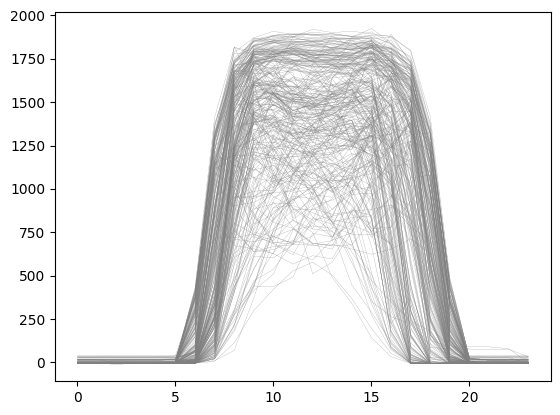

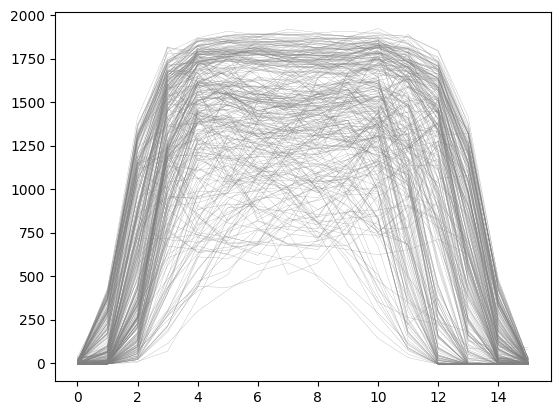

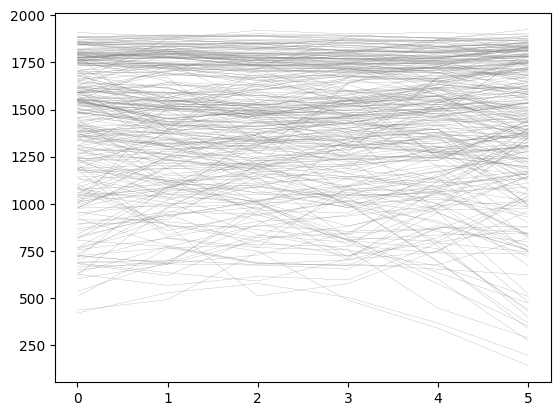

(14, 293)


In [51]:
plt.figure()
plt.plot(V_, color = 'gray', linewidth = .15)
plt.show()

plt.figure()
plt.plot(V_[5:-3, :], color = 'gray', linewidth = .15)
plt.show()

plt.figure()
plt.plot(V_[10:-8, :], color = 'gray', linewidth = .15)
plt.show()
print(V_[6:-4, :].shape)

In [52]:
# Use daylight data and align DST with solar time
def _DST_aligning_solar_data(V_, W_, X_, Y_, Z_):
    
    # Daylight DST days to solar time
    idx_dst_0_ = np.array([False, False, False, False, False, True,
                           True, True, True, True, True, True,
                           True, True, True, True, True, True,
                           True, True, True, False, False, False])
    idx_dst_1_ = np.array([False, False, False, False, False, True,
                           True, True, True, True, True, True,
                           True, True, True, True, True, True,
                           True, True, True, False, False, False])
    # Find DST days and no-DST days
    idx_dts_p_0_ = Z_[0, :, -2] == 0.
    idx_dts_p_1_ = Z_[0, :, -2] != 0.
    # Correct shifting finltering out DST and no-DST days
    V_p_0_ = V_[idx_dst_0_, :][:, idx_dts_p_0_]
    V_p_1_ = V_[idx_dst_1_, :][:, idx_dts_p_1_]
    W_p_0_ = W_[idx_dst_0_, :][:, idx_dts_p_0_]
    W_p_1_ = W_[idx_dst_1_, :][:, idx_dts_p_1_]
    X_p_0_ = X_[idx_dst_0_, :, :][:, idx_dts_p_0_, :]
    X_p_1_ = X_[idx_dst_1_, :, :][:, idx_dts_p_1_, :]
    Y_p_0_ = Y_[idx_dst_0_, :, :][:, idx_dts_p_0_, :]
    Y_p_1_ = Y_[idx_dst_1_, :, :][:, idx_dts_p_1_, :]
    Z_p_0_ = Z_[idx_dst_0_, :, :][:, idx_dts_p_0_, :]
    Z_p_1_ = Z_[idx_dst_1_, :, :][:, idx_dts_p_1_, :]
    # Recostruct time series
    V_p_ = np.zeros((idx_dst_0_.sum(), V_.shape[-1]))
    W_p_ = np.zeros((idx_dst_0_.sum(), W_.shape[-1]))
    X_p_ = np.zeros((idx_dst_0_.sum(), X_.shape[1], X_.shape[2]))
    Y_p_ = np.zeros((idx_dst_0_.sum(), Y_.shape[1], Y_.shape[2]))
    Z_p_ = np.zeros((idx_dst_0_.sum(), Z_.shape[1], Z_.shape[2]))
    # Correct DST shifting
    V_p_[:, idx_dts_p_0_]    = V_p_0_
    V_p_[:, idx_dts_p_1_]    = V_p_1_
    W_p_[:, idx_dts_p_0_]    = W_p_0_
    W_p_[:, idx_dts_p_1_]    = W_p_1_
    X_p_[:, idx_dts_p_0_, :] = X_p_0_
    X_p_[:, idx_dts_p_1_, :] = X_p_1_
    Y_p_[:, idx_dts_p_0_, :] = Y_p_0_
    Y_p_[:, idx_dts_p_1_, :] = Y_p_1_    
    Z_p_[:, idx_dts_p_0_, :] = Z_p_0_
    Z_p_[:, idx_dts_p_1_, :] = Z_p_1_  
    return V_p_, W_p_, X_p_, Y_p_, Z_p_

# Filtering out daylight hours and correct DST shifting
V_, W_, X_, Y_, Z_ = _DST_aligning_solar_data(V_, W_, X_, Y_, Z_)
print(V_.shape, W_.shape, X_.shape, Y_.shape, Z_.shape)

(16, 293) (16, 293) (16, 293, 27456) (16, 293, 27456) (16, 293, 9)


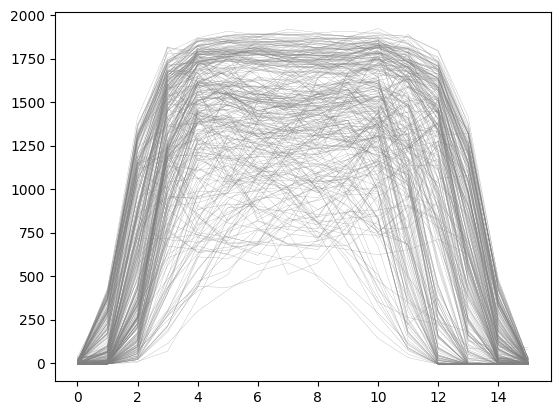

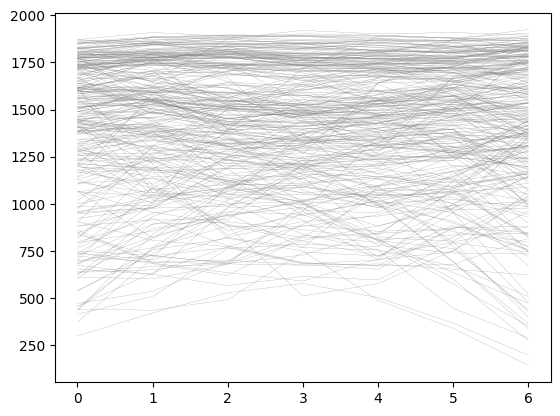

(16, 293) (9, 293)


In [53]:
plt.figure()
plt.plot(V_, color = 'gray', linewidth = .15)
plt.show()

plt.figure()
plt.plot(V_[4:-5], color = 'gray', linewidth = .15)
plt.show()

print(V_.shape, V_[4:-3].shape)

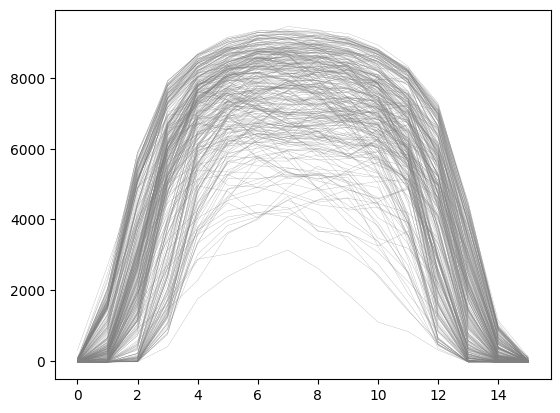

(16, 293)


In [34]:
plt.figure()
plt.plot(V_, color = 'gray', linewidth = .15)
plt.show()

print(V_.shape)

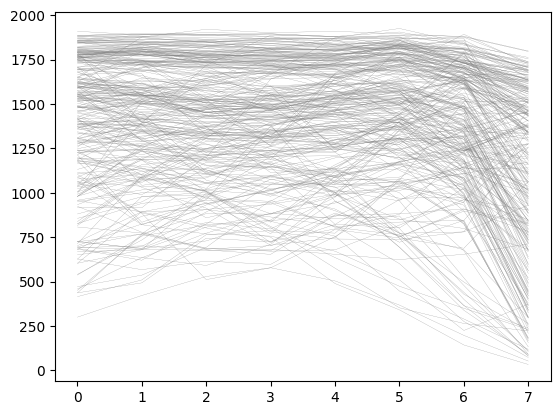

(8, 293)


In [25]:
plt.figure()
plt.plot(V_, color = 'gray', linewidth = .15)
plt.show()

print(V_.shape)

In [6]:
# Autocorrelation Function
def _ACF(x_, lag):
    return np.array([1] + [np.corrcoef(x_[:-i], x_[i:])[0, 1]  \
        for i in range(1, lag + 1)])[1:][:, np.newaxis]

# Persistent Ferecast
def _persistence(Y_):
    return Y_[:, :-1]

# Climatological Ferecast
def _climatology(Y_, lag = 6):
    N_predictions = Y_.shape[-1]- lag
    Y_hat_ = []
    for n in range(1, N_predictions):
        k = -n
        l = -n - lag
        Y_hat_.append(np.mean(Y_[:, l:k], axis = 1)[:, np.newaxis])
    return np.concatenate(Y_hat_, axis = 1)[:, ::-1]

# Covex Climatological Ferecast
def _convex_climatology_persistence(Y_cli_, Y_per_, ACF_):
    Y_cov_ = np.zeros(Y_per_.shape)
    for i in range(ACF_.shape[0]):
        Y_cov_[:, i] = Y_per_[:, i]*ACF_[i] + Y_cli_[:, i]*(1. - ACF_[i])
    return Y_cov_

lag  = 4
r_cv = .75

ACF_ = np.concatenate([_ACF(V_[i, :], 1) for i in range(V_.shape[0])], axis = 1)[0, :].T

# Compute the forecast baseilse
Y_per_hat_p_ = _persistence(V_)[:, lag:].T
Y_cli_hat_p_ = _climatology(V_, lag)[:, :].T
Y_cov_hat_p_ = _convex_climatology_persistence(Y_cli_hat_p_, Y_per_hat_p_, ACF_)
print(Y_per_hat_p_.shape, Y_cli_hat_p_.shape, Y_cov_hat_p_.shape)

# Align Dataset with baseline forecats / time series
V_p_ = V_[:, lag + 1:].T
W_p_ = W_[:, lag + 1:].T
print(V_p_.shape, W_p_.shape)
X_p_ = np.swapaxes(X_, 0, 2)[:, lag + 1:, :]
Y_p_ = np.swapaxes(Y_, 0, 2)[:, lag + 1:, :]
Z_p_ = np.swapaxes(Z_, 0, 2)[:, lag + 1:, :]
print(X_p_.shape, Y_p_.shape, Z_p_.shape)

# Compute Dataset samples in training and testing partition
N_day_samples, N_hours = V_p_.shape
N_day_samples_tr       = int(N_day_samples*r_cv)
N_day_samples_ts       = N_day_samples - N_day_samples_tr
print(N_hours, N_day_samples, N_day_samples_tr, N_day_samples_ts)

Y_per_hat_p_tr_ = Y_per_hat_p_[:N_day_samples_tr, :]
Y_per_hat_p_ts_ = Y_per_hat_p_[-N_day_samples_ts:, :]
print(Y_per_hat_p_tr_.shape, Y_per_hat_p_ts_.shape)

Y_cli_hat_p_tr_ = Y_cli_hat_p_[:N_day_samples_tr, :]
Y_cli_hat_p_ts_ = Y_cli_hat_p_[-N_day_samples_ts:, :]
print(Y_cli_hat_p_tr_.shape, Y_cli_hat_p_ts_.shape)

Y_cov_hat_p_tr_ = Y_cov_hat_p_[:N_day_samples_tr, :]
Y_cov_hat_p_ts_ = Y_cov_hat_p_[-N_day_samples_ts:, :]
print(Y_cov_hat_p_tr_.shape, Y_cov_hat_p_ts_.shape)

V_p_tr_ = V_p_[:N_day_samples_tr, :]
V_p_ts_ = V_p_[-N_day_samples_ts:, :]
print(V_p_tr_.shape, V_p_ts_.shape)

W_p_tr_ = W_p_[:N_day_samples_tr, :]
W_p_ts_ = W_p_[-N_day_samples_ts:, :]
print(W_p_tr_.shape, W_p_ts_.shape)

X_p_tr_ = X_p_[:, :N_day_samples_tr, :]
X_p_ts_ = X_p_[:, -N_day_samples_ts:, :]
print(X_p_tr_.shape, X_p_ts_.shape)

Y_p_tr_ = Y_p_[:, :N_day_samples_tr, :]
Y_p_ts_ = Y_p_[:, -N_day_samples_ts:, :]
print(Y_p_tr_.shape, Y_p_ts_.shape)

Z_p_tr_ = Z_p_[[0, 3], :N_day_samples_tr, :]
Z_p_ts_ = Z_p_[[0, 3], -N_day_samples_ts:, :]
print(Z_p_tr_.shape, Z_p_ts_.shape)

# Form Autoregresive features
V_ar_ = []
for l in range(lag):
    V_ar_.append(V_[:, lag -l:-1 -l][..., np.newaxis])
V_ar_ = np.concatenate(V_ar_, axis = 2)
print(V_ar_.shape)

V_ar_tr_ = np.swapaxes(V_ar_[:, :N_day_samples_tr, :], 0, 2)
V_ar_ts_ = np.swapaxes(V_ar_[:, -N_day_samples_ts:, :], 0, 2)
print(V_ar_tr_.shape, V_ar_ts_.shape)

(590, 10) (590, 10) (590, 10)
(590, 10) (590, 10)
(20694, 590, 10) (20694, 590, 10) (9, 590, 10)
10 590 442 148
(442, 10) (148, 10)
(442, 10) (148, 10)
(442, 10) (148, 10)
(442, 10) (148, 10)
(442, 10) (148, 10)
(20694, 442, 10) (20694, 148, 10)
(20694, 442, 10) (20694, 148, 10)
(2, 442, 10) (2, 148, 10)
(10, 590, 4)
(4, 442, 10) (4, 148, 10)


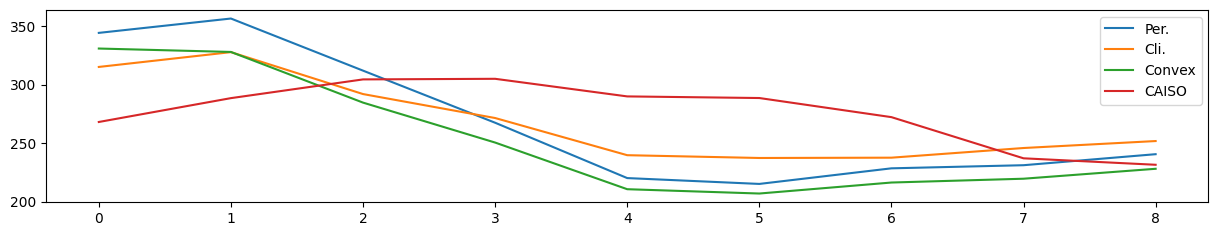

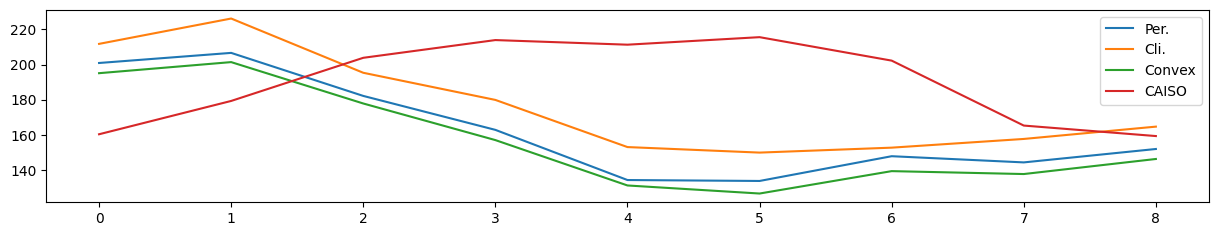

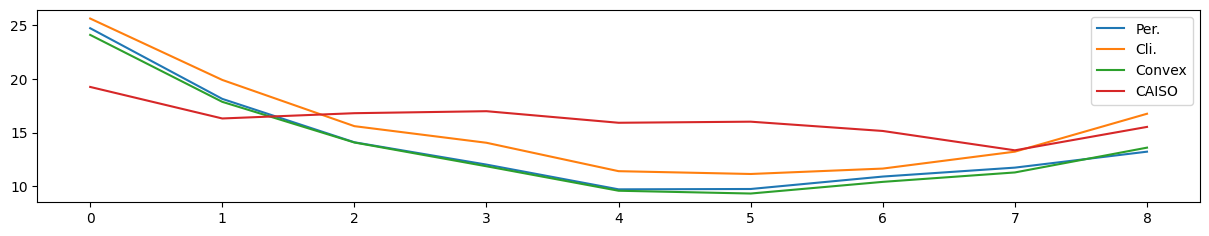

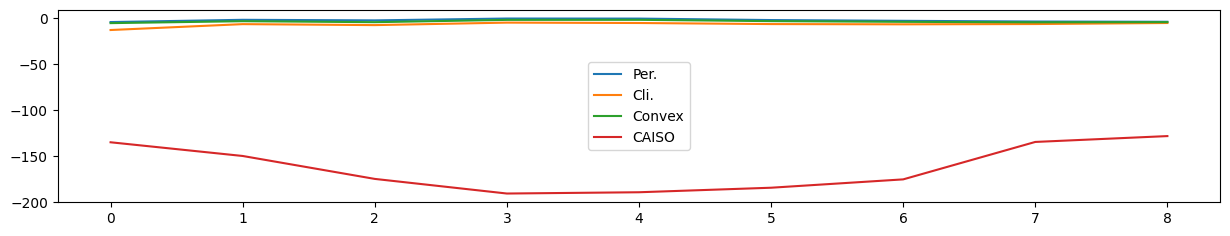

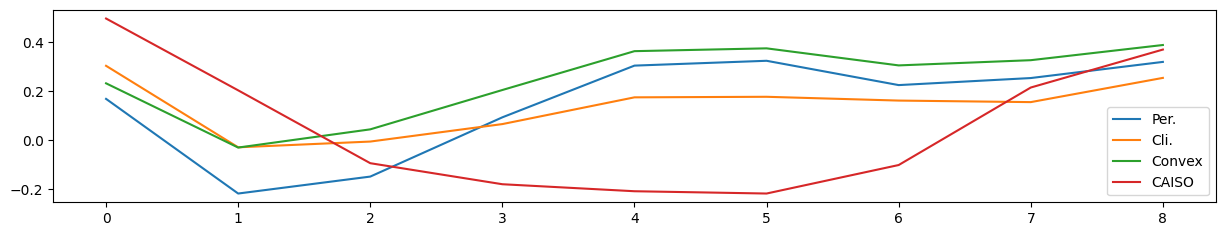

In [7]:
# Root Mean Squared Error
def _RMSE(Y_, Y_hat_):
    return np.sqrt(np.mean((Y_ - Y_hat_)**2, axis = 0))

# Mean Absolute Error
def _MAE(Y_, Y_hat_):
    return np.mean(np.absolute(Y_ - Y_hat_), axis = 0)

# Mean Absolute Percentage Error
def _MAPE(Y_, Y_hat_):
    return 100.*np.mean(np.absolute((Y_ - Y_hat_)/Y_), axis = 0)

# Mean Bias Error
def _MBE(Y_, Y_hat_):
    return np.mean((Y_ - Y_hat_), axis = 0)

# Coefficient of determination
def _R2(Y_, Y_hat_):
    return 1. - (np.sum((Y_ - Y_hat_)**2, axis = 0)/np.sum((Y_ - np.mean(Y_))**2, axis = 0))

RMSE_PER_ = [_RMSE(V_p_ts_[..., i], Y_per_hat_p_ts_[..., i]) for i in range(N_hours)]
MAE_PER_  = [_MAE(V_p_ts_[..., i], Y_per_hat_p_ts_[..., i]) for i in range(N_hours)]
MAPE_PER_ = [_MAPE(V_p_ts_[..., i], Y_per_hat_p_ts_[..., i]) for i in range(N_hours)]
MBE_PER_  = [_MBE(V_p_ts_[..., i], Y_per_hat_p_ts_[..., i]) for i in range(N_hours)]
R2_PER_   = [_R2(V_p_ts_[..., i], Y_per_hat_p_ts_[..., i]) for i in range(N_hours)]

RMSE_CLI_ = [_RMSE(V_p_ts_[..., i], Y_cli_hat_p_ts_[..., i]) for i in range(N_hours)]
MAE_CLI_  = [_MAE(V_p_ts_[..., i], Y_cli_hat_p_ts_[..., i]) for i in range(N_hours)]
MAPE_CLI_ = [_MAPE(V_p_ts_[..., i], Y_cli_hat_p_ts_[..., i]) for i in range(N_hours)]
MBE_CLI_  = [_MBE(V_p_ts_[..., i], Y_cli_hat_p_ts_[..., i]) for i in range(N_hours)]
R2_CLI_   = [_R2(V_p_ts_[..., i], Y_cli_hat_p_ts_[..., i]) for i in range(N_hours)]

RMSE_COV_ = [_RMSE(V_p_ts_[..., i], Y_cov_hat_p_ts_[..., i]) for i in range(N_hours)]
MAE_COV_  = [_MAE(V_p_ts_[..., i], Y_cov_hat_p_ts_[..., i]) for i in range(N_hours)]
MAPE_COV_ = [_MAPE(V_p_ts_[..., i], Y_cov_hat_p_ts_[..., i]) for i in range(N_hours)]
MBE_COV_  = [_MBE(V_p_ts_[..., i], Y_cov_hat_p_ts_[..., i]) for i in range(N_hours)]
R2_COV_   = [_R2(V_p_ts_[..., i], Y_cov_hat_p_ts_[..., i]) for i in range(N_hours)]

RMSE_W_ = [_RMSE(V_p_ts_[..., i], W_p_ts_[..., i]) for i in range(N_hours)]
MAE_W_  = [_MAE(V_p_ts_[..., i], W_p_ts_[..., i]) for i in range(N_hours)]
MAPE_W_ = [_MAPE(V_p_ts_[..., i], W_p_ts_[..., i]) for i in range(N_hours)]
MBE_W_  = [_MBE(V_p_ts_[..., i], W_p_ts_[..., i]) for i in range(N_hours)]
R2_W_   = [_R2(V_p_ts_[..., i], W_p_ts_[..., i]) for i in range(N_hours)]

plt.figure(figsize = (15, 2.5))
plt.plot(RMSE_PER_[:-1], label = 'Per.')
plt.plot(RMSE_CLI_[:-1], label = 'Cli.')
plt.plot(RMSE_COV_[:-1], label = 'Convex')
plt.plot(RMSE_W_[:-1], label = 'CAISO')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAE_PER_[:-1], label = 'Per.')
plt.plot(MAE_CLI_[:-1], label = 'Cli.')
plt.plot(MAE_COV_[:-1], label = 'Convex')
plt.plot(MAE_W_[:-1], label = 'CAISO')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAPE_PER_[:-1], label = 'Per.')
plt.plot(MAPE_CLI_[:-1], label = 'Cli.')
plt.plot(MAPE_COV_[:-1], label = 'Convex')
plt.plot(MAPE_W_[:-1], label = 'CAISO')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MBE_PER_[:-1], label = 'Per.')
plt.plot(MBE_CLI_[:-1], label = 'Cli.')
plt.plot(MBE_COV_[:-1], label = 'Convex')
plt.plot(MBE_W_[:-1], label = 'CAISO')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(R2_PER_[:-1], label = 'Per.')
plt.plot(R2_CLI_[:-1], label = 'Cli.')
plt.plot(R2_COV_[:-1], label = 'Convex')
plt.plot(R2_W_[:-1], label = 'CAISO')
plt.legend()
plt.show()

In [11]:
# Defien data structure to train a global model
def _global_model_structure(X_, Y_):
    X_p_, y_p_ = [], []
    # Concatenate all days in a single calumn
    for i_day in range(Y_.shape[0]):
        X_p_.append(X_[:, i_day, :])
        y_p_.append(Y_[i_day, :])
    X_p_ = np.concatenate(X_p_, axis = 1).T
    y_p_ = np.concatenate(y_p_, axis = 0)[:, np.newaxis]
    return X_p_, y_p_

print(X_p_tr_.shape, V_p_tr_.shape, X_p_ts_.shape, V_p_ts_.shape)
# Define Dataset for the structure of a global model 
X_tr_, y_tr_ = _global_model_structure(Y_p_tr_, V_p_tr_)
X_ts_, y_ts_ = _global_model_structure(Y_p_ts_, V_p_ts_)
print(X_tr_.shape, y_tr_.shape, X_ts_.shape, y_ts_.shape)
# Define Standardizataion functions
_X_scaler = StandardScaler().fit(X_tr_)
_y_scaler = StandardScaler().fit(y_tr_)
print(_X_scaler.mean_.shape, _y_scaler.mean_.shape)
# Standardize dataset
X_tr_p_ = _X_scaler.transform(X_tr_)
X_ts_p_ = _X_scaler.transform(X_ts_)
y_tr_p_ = _y_scaler.transform(y_tr_)[:, 0]
y_ts_p_ = _y_scaler.transform(y_ts_)[:, 0]
print(X_tr_p_.shape, y_tr_p_.shape, X_ts_p_.shape, y_ts_p_.shape)

(20694, 442, 10) (442, 10) (20694, 148, 10) (148, 10)
(4420, 20694) (4420, 1) (1480, 20694) (1480, 1)
(20694,) (1,)
(4420, 20694) (4420,) (1480, 20694) (1480,)


(20694,) 400
3 6898 400


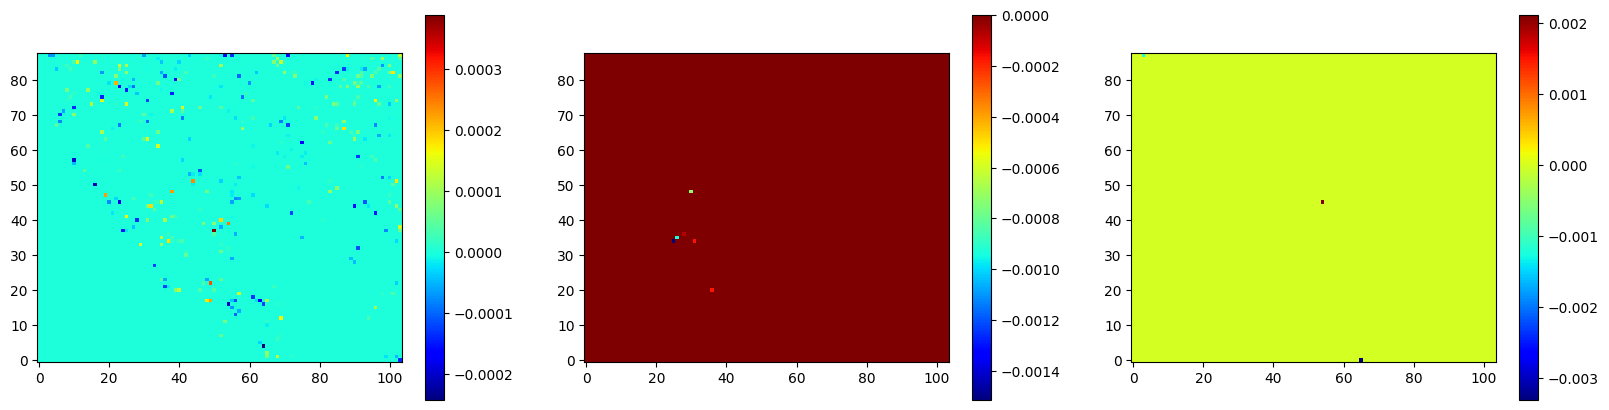

In [13]:
N_features = 3
# Find most important Feartures
# _LL = Lasso(alpha     = 1., 
#             max_iter  = 1000).fit(X_tr_, y_tr_p_)
_LL = LassoLars(alpha     = 1., 
                max_iter  = 500, 
                normalize = False).fit(X_tr_, y_tr_p_)
# _LL = LassoLarsIC(criterion ='aic',
#                   max_iter  = 500, 
#                   normalize = False).fit(X_tr_, y_tr_p_)
# _LL = LassoLarsIC(criterion ='bic',
#                   max_iter  = 500, 
#                   normalize = False).fit(X_tr_, y_tr_p_)
# _LL = OrthogonalMatchingPursuit(n_nonzero_coefs = 500, 
#                                 normalize       = False).fit(X_tr_, y_tr_p_)
# Get Lasso sparse coefficients
w_   = _LL.coef_
idx_ = w_ != 0.
print(w_.shape, idx_.sum())

# Reconstruct spatial distribution of the coefficients
N_dimensions         = int(w_.shape[0]/N_features)
B_                   = np.zeros((3, US_land_.shape[0],))
B_[:, US_land_ > 0.] = np.reshape(w_, (N_features, N_dimensions))
print(N_features, N_dimensions, idx_.sum())

plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.imshow(np.reshape(B_[0, ...], (M, N)), cmap   = 'jet', 
                                           origin = 'lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(np.reshape(B_[1, ...], (M, N)), cmap   = 'jet', 
                                           origin = 'lower')
plt.colorbar()
plt.subplot(133)
plt.imshow(np.reshape(B_[2, ...], (M, N)), cmap   = 'jet', 
                                           origin = 'lower')
plt.colorbar()
plt.show()

(1480, 20694) (20694, 148, 10) (1480,)
(148, 10) (148, 10)


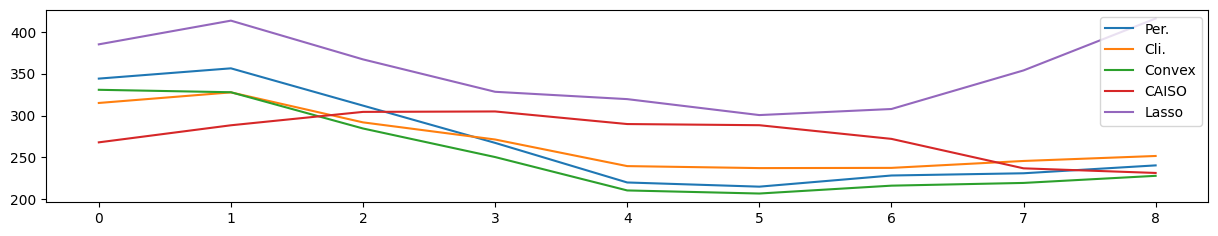

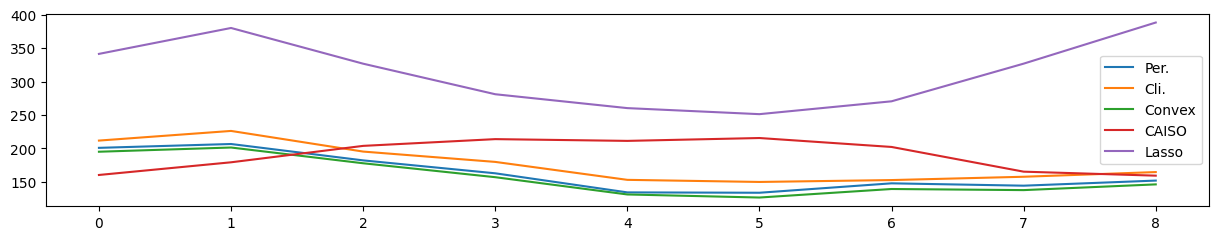

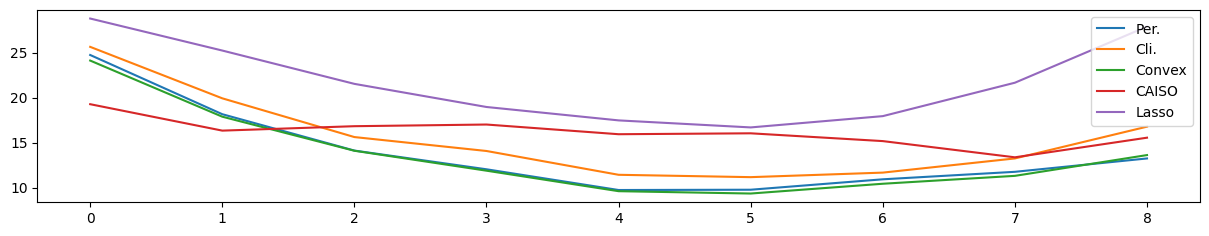

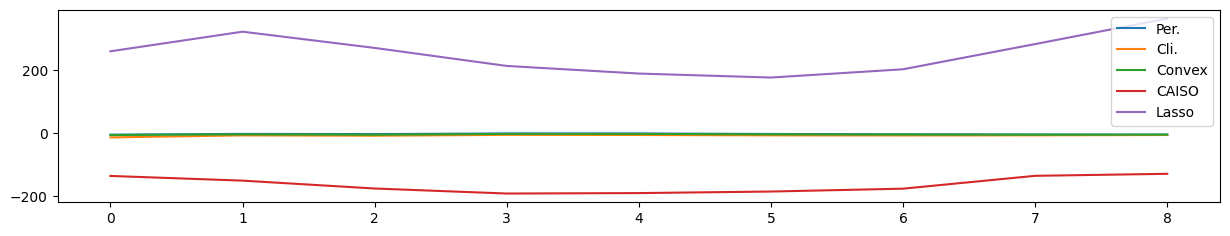

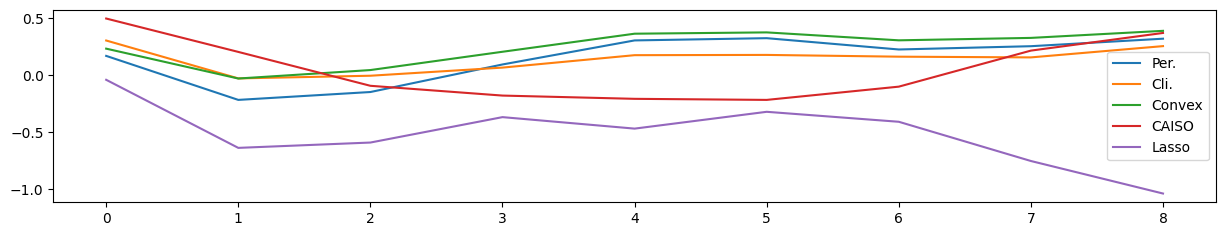

In [ ]:
# Defien data structure to train a global model
def _revert_global_model_structure(X_, Y_, N_hours):
    N_samples  = Y_.shape[0]
    N_days     = int(N_samples/N_hours)
    X_p_, y_p_ = [], []
    # Concatenate all days in a single calumn
    for i_day in range(N_days):
        i = i_day*N_hours
        j = (i_day + 1)*N_hours
        
        X_p_.append(X_[i:j, :][np.newaxis, ...])
        y_p_.append(Y_[i:j][:, np.newaxis])
        
    X_p_ = np.swapaxes(np.concatenate(X_p_, axis = 0).T, 1, 2)
    y_p_ = np.concatenate(y_p_, axis = 1).T
    return X_p_, y_p_

y_ts_hat_LL_ = _y_scaler.inverse_transform(_LL.predict(X_ts_)[:, np.newaxis])[:, 0]
print(X_ts_.shape, Y_p_ts_.shape, y_ts_hat_LL_.shape)

_, V_p_ts_hat_LL_ = _revert_global_model_structure(X_ts_, y_ts_hat_LL_, N_hours = N_hours)
print(V_p_ts_.shape, V_p_ts_hat_LL_.shape)

RMSE_LL_ = [_RMSE(V_p_ts_[..., i], V_p_ts_hat_LL_[..., i]) for i in range(N_hours)]
MAE_LL_  = [_MAE(V_p_ts_[..., i], V_p_ts_hat_LL_[..., i]) for i in range(N_hours)]
MAPE_LL_ = [_MAPE(V_p_ts_[..., i], V_p_ts_hat_LL_[..., i]) for i in range(N_hours)]
MBE_LL_  = [_MBE(V_p_ts_[..., i], V_p_ts_hat_LL_[..., i]) for i in range(N_hours)]
R2_LL_   = [_R2(V_p_ts_[..., i], V_p_ts_hat_LL_[..., i]) for i in range(N_hours)]

plt.figure(figsize = (15, 2.5))
plt.plot(RMSE_PER_[:-1], label = 'Per.')
plt.plot(RMSE_CLI_[:-1], label = 'Cli.')
plt.plot(RMSE_COV_[:-1], label = 'Convex')
plt.plot(RMSE_W_[:-1], label = 'CAISO')
plt.plot(RMSE_LL_[:-1], label = 'Lasso')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAE_PER_[:-1], label = 'Per.')
plt.plot(MAE_CLI_[:-1], label = 'Cli.')
plt.plot(MAE_COV_[:-1], label = 'Convex')
plt.plot(MAE_W_[:-1], label = 'CAISO')
plt.plot(MAE_LL_[:-1], label = 'Lasso')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAPE_PER_[:-1], label = 'Per.')
plt.plot(MAPE_CLI_[:-1], label = 'Cli.')
plt.plot(MAPE_COV_[:-1], label = 'Convex')
plt.plot(MAPE_W_[:-1], label = 'CAISO')
plt.plot(MAPE_LL_[:-1], label = 'Lasso')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MBE_PER_[:-1], label = 'Per.')
plt.plot(MBE_CLI_[:-1], label = 'Cli.')
plt.plot(MBE_COV_[:-1], label = 'Convex')
plt.plot(MBE_W_[:-1], label = 'CAISO')
plt.plot(MBE_LL_[:-1], label = 'Lasso')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(R2_PER_[:-1], label = 'Per.')
plt.plot(R2_CLI_[:-1], label = 'Cli.')
plt.plot(R2_COV_[:-1], label = 'Convex')
plt.plot(R2_W_[:-1], label = 'CAISO')
plt.plot(R2_LL_[:-1], label = 'Lasso')
plt.legend()
plt.show()

In [30]:
chain = 1

Y_pp_tr_ = np.concatenate((Y_p_tr_, V_ar_tr_, Z_p_tr_), axis = 0)
Y_pp_ts_ = np.concatenate((Y_p_ts_, V_ar_ts_, Z_p_ts_), axis = 0)
# Y_pp_tr_ = np.concatenate((Y_p_tr_, V_ar_tr_), axis = 0)
# Y_pp_ts_ = np.concatenate((Y_p_ts_, V_ar_ts_), axis = 0)
# Y_pp_tr_ = V_ar_tr_.copy()
# Y_pp_ts_ = V_ar_ts_.copy()
print(Y_pp_tr_.shape, Y_pp_ts_.shape)

idx_p_ = np.concatenate((idx_, np.array((Y_pp_tr_.shape[0] - idx_.shape[0])*[True])), axis = 0)
print(Y_pp_tr_.shape, Y_pp_ts_.shape, V_p_tr_.shape, V_p_ts_.shape)

y_tr_p_hat_LL_,  y_ts_p_hat_LL_  = [], []
y_tr_p_hat_RR_,  y_ts_p_hat_RR_  = [], []
y_tr_p_hat_ARD_, y_ts_p_hat_ARD_ = [], []
y_tr_p_hat_BLR_, y_ts_p_hat_BLR_ = [], []
y_tr_p_hat_GPR_, y_ts_p_hat_GPR_ = [], []

y_ts_hat_LL_  = np.zeros((V_p_ts_.shape))
y_ts_hat_RR_  = np.zeros((V_p_ts_.shape))
y_ts_hat_ARD_ = np.zeros((V_p_ts_.shape))
y_ts_hat_BLR_ = np.zeros((V_p_ts_.shape))
y_ts_hat_GPR_ = np.zeros((V_p_ts_.shape))

for i in range(N_hours):
    
    print(i)
    # Define Training and testing set
    X_tr_ = Y_pp_tr_[idx_p_, :, i].T
    X_ts_ = Y_pp_ts_[idx_p_, :, i].T
    # X_tr_ = Y_pp_tr_[..., i].T
    # X_ts_ = Y_pp_ts_[..., i].T
    y_tr_ = V_p_tr_[..., i]
    y_ts_ = V_p_ts_[..., i]
    #print(X_tr_.shape, X_ts_.shape, y_tr_.shape, y_ts_.shape)
    # Define Standardizataion functions
    _X_scaler = StandardScaler().fit(X_tr_)
    _y_scaler = StandardScaler().fit(y_tr_[:, np.newaxis])
    #print(_X_scaler.mean_.shape, _y_scaler.mean_.shape)
    # Standardize dataset
    X_tr_p_ = _X_scaler.transform(X_tr_)
    X_ts_p_ = _X_scaler.transform(X_ts_)
    y_tr_p_ = _y_scaler.transform(y_tr_[:, np.newaxis])[:, 0]
    y_ts_p_ = _y_scaler.transform(y_ts_[:, np.newaxis])[:, 0]
        
    if (chain) & (len(y_tr_p_hat_LL_) > 0):
        X_tr_p_chain_ = np.concatenate((X_tr_p_, np.array(y_tr_p_hat_LL_).T), axis = 1)
        X_ts_p_chain_ = np.concatenate((X_ts_p_, np.array(y_ts_p_hat_LL_).T), axis = 1)
        X_tr_chain_   = np.concatenate((X_tr_, np.array(y_tr_p_hat_LL_).T), axis = 1)
        X_ts_chain_   = np.concatenate((X_ts_, np.array(y_ts_p_hat_LL_).T), axis = 1)
    else:
        X_tr_p_chain_ = X_tr_p_.copy()
        X_ts_p_chain_ = X_ts_p_.copy()
        X_tr_chain_   = X_tr_.copy()
        X_ts_chain_   = X_ts_.copy()
    print(X_tr_chain_.shape, X_tr_p_chain_.shape, X_ts_chain_.shape, X_ts_p_chain_.shape)

    # Lasso LARS
    _LL = LassoLars(alpha     = 1., 
                    max_iter  = 100, 
                    normalize = False).fit(X_tr_chain_, y_tr_p_)
    
    # Linear ridge regression
    _RR = Ridge(alpha = 0.001).fit(X_tr_p_chain_, y_tr_p_)
    
    # Bayesian Linear Regression with ARD mechanims
    _ARD = ARDRegression(threshold_lambda = 100, 
                         n_iter           = 300, 
                         tol              = 0.001).fit(X_tr_p_chain_, y_tr_p_)
    
    # Bayesian Linear Regression
    _BLR = BayesianRidge(n_iter = 300, 
                         tol    = 0.001).fit(X_tr_p_chain_, y_tr_p_)

    _kernel_lin  = 1 * DotProduct(sigma_0        = 1., 
                                  sigma_0_bounds = (1e-5, 1e5))
    
    _kernel_poly = 1 * DotProduct(sigma_0        = 1., 
                                  sigma_0_bounds = (1e-5, 1e5))**2
    
    _kernel_RBF  = 1 * RBF(length_scale        = 1., 
                           length_scale_bounds = (1e-5, 1e5)) + 1
    
    _kernel_RQ   = 1 * RationalQuadratic(length_scale        = 1., 
                                         alpha               = 0.1, 
                                         length_scale_bounds = (1e-5, 1e5), 
                                         alpha_bounds        = (1e-5, 1e5)) + 1
    
    _kernel_M05  = 1 * Matern(length_scale        = 1.0, 
                              length_scale_bounds = (1e-5,  1e5), 
                              nu                  = 0.5) + 1
    
    _kernel_M15  = 1 * Matern(length_scale        = 1.0, 
                              length_scale_bounds = (1e-5,  1e5), 
                              nu                  = 1.5) + 1
    
    _kernel_M25  = 1 * Matern(length_scale        = 1.0, 
                              length_scale_bounds = (1e-5,  1e5), 
                              nu                  = 2.5) + 1
    
    _GPR = GaussianProcessRegressor(kernel               = _kernel_RQ, 
                                    alpha                = 1e-10,
                                    n_restarts_optimizer = 3).fit(X_tr_p_chain_, y_tr_p_)
    # Predictor chain for training
    y_tr_p_hat_LL_.append(_LL.predict(X_tr_chain_))
    y_tr_p_hat_RR_.append(_RR.predict(X_tr_p_chain_))
    y_tr_p_hat_ARD_.append(_ARD.predict(X_tr_p_chain_))
    y_tr_p_hat_BLR_.append(_BLR.predict(X_tr_p_chain_))
    y_tr_p_hat_GPR_.append(_GPR.predict(X_tr_p_chain_, return_std = False))
    # Predictor chain for testing
    y_ts_p_hat_LL_.append(_LL.predict(X_ts_chain_))
    y_ts_p_hat_RR_.append(_RR.predict(X_ts_p_chain_))
    y_ts_p_hat_ARD_.append(_ARD.predict(X_ts_p_chain_))
    y_ts_p_hat_BLR_.append(_BLR.predict(X_ts_p_chain_))
    y_ts_p_hat_GPR_.append(_GPR.predict(X_ts_p_chain_, return_std = False))

    # Gather predictions
    y_ts_hat_LL_[:, i]  = _y_scaler.inverse_transform(y_ts_p_hat_LL_[-1][:, np.newaxis])[:, 0]
    y_ts_hat_RR_[:, i]  = _y_scaler.inverse_transform(y_ts_p_hat_RR_[-1][:, np.newaxis])[:, 0]
    y_ts_hat_ARD_[:, i] = _y_scaler.inverse_transform(y_ts_p_hat_ARD_[-1][:, np.newaxis])[:, 0]
    y_ts_hat_BLR_[:, i] = _y_scaler.inverse_transform(y_ts_p_hat_BLR_[-1][:, np.newaxis])[:, 0]
    y_ts_hat_GPR_[:, i] = _y_scaler.inverse_transform(y_ts_p_hat_GPR_[-1][:, np.newaxis])[:, 0]

(20700, 442, 10) (20700, 148, 10)
(20700, 442, 10) (20700, 148, 10) (442, 10) (148, 10)
0
(442, 406) (442, 406) (148, 406) (148, 406)
1
(442, 407) (442, 407) (148, 407) (148, 407)


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


2
(442, 408) (442, 408) (148, 408) (148, 408)


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


3
(442, 409) (442, 409) (148, 409) (148, 409)
4
(442, 410) (442, 410) (148, 410) (148, 410)
5
(442, 411) (442, 411) (148, 411) (148, 411)


/Users/Guille/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


6
(442, 412) (442, 412) (148, 412) (148, 412)
7
(442, 413) (442, 413) (148, 413) (148, 413)
8
(442, 414) (442, 414) (148, 414) (148, 414)
9
(442, 415) (442, 415) (148, 415) (148, 415)


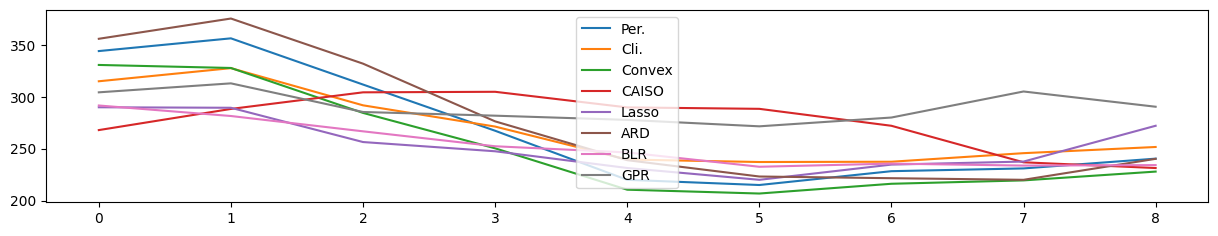

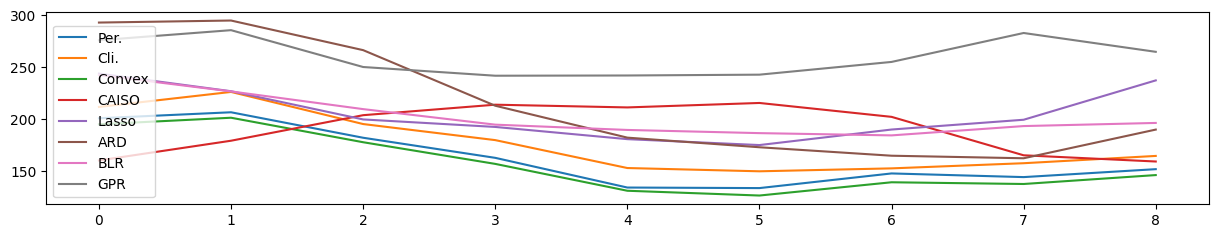

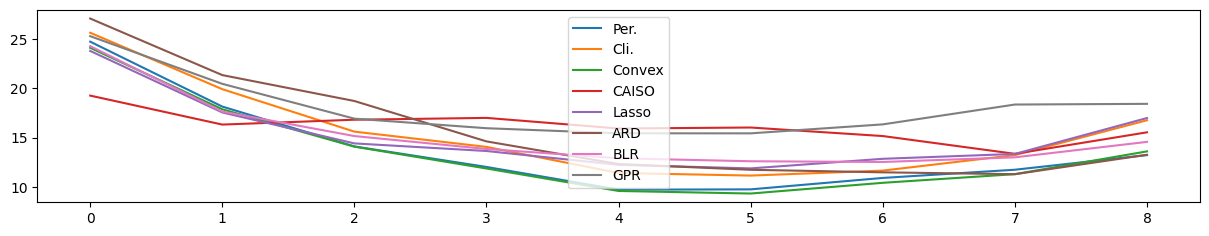

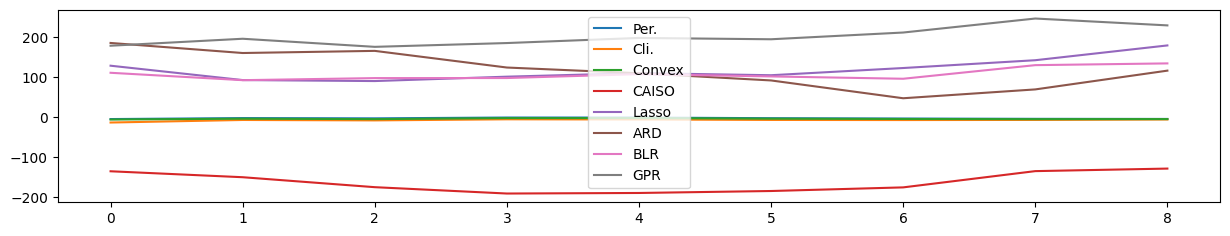

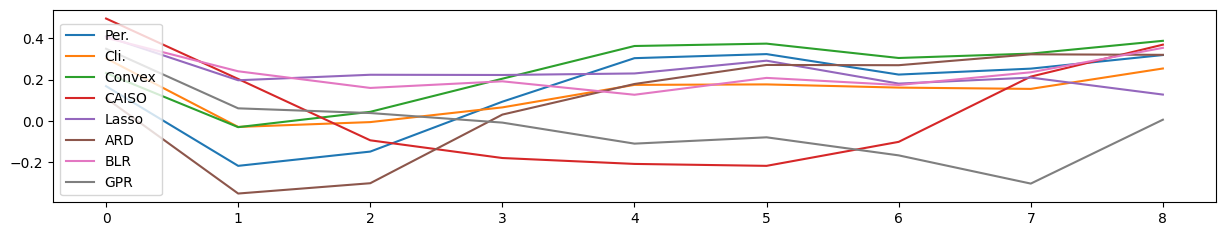

In [31]:
RMSE_LL_ = [_RMSE(V_p_ts_[..., i], y_ts_hat_LL_[..., i]) for i in range(N_hours)]
MAE_LL_  = [_MAE(V_p_ts_[..., i], y_ts_hat_LL_[..., i]) for i in range(N_hours)]
MAPE_LL_ = [_MAPE(V_p_ts_[..., i], y_ts_hat_LL_[..., i]) for i in range(N_hours)]
MBE_LL_  = [_MBE(V_p_ts_[..., i], y_ts_hat_LL_[..., i]) for i in range(N_hours)]
R2_LL_   = [_R2(V_p_ts_[..., i], y_ts_hat_LL_[..., i]) for i in range(N_hours)]

RMSE_RR_ = [_RMSE(V_p_ts_[..., i], y_ts_hat_RR_[..., i]) for i in range(N_hours)]
MAE_RR_  = [_MAE(V_p_ts_[..., i], y_ts_hat_RR_[..., i]) for i in range(N_hours)]
MAPE_RR_ = [_MAPE(V_p_ts_[..., i], y_ts_hat_RR_[..., i]) for i in range(N_hours)]
MBE_RR_  = [_MBE(V_p_ts_[..., i], y_ts_hat_RR_[..., i]) for i in range(N_hours)]
R2_RR_   = [_R2(V_p_ts_[..., i], y_ts_hat_RR_[..., i]) for i in range(N_hours)]

RMSE_ARD_ = [_RMSE(V_p_ts_[..., i], y_ts_hat_ARD_[..., i]) for i in range(N_hours)]
MAE_ARD_  = [_MAE(V_p_ts_[..., i], y_ts_hat_ARD_[..., i]) for i in range(N_hours)]
MAPE_ARD_ = [_MAPE(V_p_ts_[..., i], y_ts_hat_ARD_[..., i]) for i in range(N_hours)]
MBE_ARD_  = [_MBE(V_p_ts_[..., i], y_ts_hat_ARD_[..., i]) for i in range(N_hours)]
R2_ARD_   = [_R2(V_p_ts_[..., i], y_ts_hat_ARD_[..., i]) for i in range(N_hours)]

RMSE_BLR_ = [_RMSE(V_p_ts_[..., i], y_ts_hat_BLR_[..., i]) for i in range(N_hours)]
MAE_BLR_  = [_MAE(V_p_ts_[..., i], y_ts_hat_BLR_[..., i]) for i in range(N_hours)]
MAPE_BLR_ = [_MAPE(V_p_ts_[..., i], y_ts_hat_BLR_[..., i]) for i in range(N_hours)]
MBE_BLR_  = [_MBE(V_p_ts_[..., i], y_ts_hat_BLR_[..., i]) for i in range(N_hours)]
R2_BLR_   = [_R2(V_p_ts_[..., i], y_ts_hat_BLR_[..., i]) for i in range(N_hours)]

RMSE_GPR_ = [_RMSE(V_p_ts_[..., i], y_ts_hat_GPR_[..., i]) for i in range(N_hours)]
MAE_GPR_  = [_MAE(V_p_ts_[..., i], y_ts_hat_GPR_[..., i]) for i in range(N_hours)]
MAPE_GPR_ = [_MAPE(V_p_ts_[..., i], y_ts_hat_GPR_[..., i]) for i in range(N_hours)]
MBE_GPR_  = [_MBE(V_p_ts_[..., i], y_ts_hat_GPR_[..., i]) for i in range(N_hours)]
R2_GPR_   = [_R2(V_p_ts_[..., i], y_ts_hat_GPR_[..., i]) for i in range(N_hours)]

plt.figure(figsize = (15, 2.5))
plt.plot(RMSE_PER_[:-1], label = 'Per.')
plt.plot(RMSE_CLI_[:-1], label = 'Cli.')
plt.plot(RMSE_COV_[:-1], label = 'Convex')
plt.plot(RMSE_W_[:-1], label = 'CAISO')
plt.plot(RMSE_LL_[:-1], label = 'Lasso')
#plt.plot(RMSE_RR_[:-1], label = 'RR')
plt.plot(RMSE_ARD_[:-1], label = 'ARD')
plt.plot(RMSE_BLR_[:-1], label = 'BLR')
plt.plot(RMSE_GPR_[:-1], label = 'GPR')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAE_PER_[:-1], label = 'Per.')
plt.plot(MAE_CLI_[:-1], label = 'Cli.')
plt.plot(MAE_COV_[:-1], label = 'Convex')
plt.plot(MAE_W_[:-1], label = 'CAISO')
plt.plot(MAE_LL_[:-1], label = 'Lasso')
#plt.plot(MAE_RR_[:-1], label = 'RR')
plt.plot(MAE_ARD_[:-1], label = 'ARD')
plt.plot(MAE_BLR_[:-1], label = 'BLR')
plt.plot(MAE_GPR_[:-1], label = 'GPR')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MAPE_PER_[:-1], label = 'Per.')
plt.plot(MAPE_CLI_[:-1], label = 'Cli.')
plt.plot(MAPE_COV_[:-1], label = 'Convex')
plt.plot(MAPE_W_[:-1], label = 'CAISO')
plt.plot(MAPE_LL_[:-1], label = 'Lasso')
#plt.plot(MAPE_RR_[:-1], label = 'RR')
plt.plot(MAPE_ARD_[:-1], label = 'ARD')
plt.plot(MAPE_BLR_[:-1], label = 'BLR')
plt.plot(MAPE_GPR_[:-1], label = 'GPR')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(MBE_PER_[:-1], label = 'Per.')
plt.plot(MBE_CLI_[:-1], label = 'Cli.')
plt.plot(MBE_COV_[:-1], label = 'Convex')
plt.plot(MBE_W_[:-1], label = 'CAISO')
plt.plot(MBE_LL_[:-1], label = 'Lasso')
#plt.plot(MBE_RR_[:-1], label = 'RR')
plt.plot(MBE_ARD_[:-1], label = 'ARD')
plt.plot(MBE_BLR_[:-1], label = 'BLR')
plt.plot(MBE_GPR_[:-1], label = 'GPR')
plt.legend()
plt.show()

plt.figure(figsize = (15, 2.5))
plt.plot(R2_PER_[:-1], label = 'Per.')
plt.plot(R2_CLI_[:-1], label = 'Cli.')
plt.plot(R2_COV_[:-1], label = 'Convex')
plt.plot(R2_W_[:-1], label = 'CAISO')
plt.plot(R2_LL_[:-1], label = 'Lasso')
#plt.plot(R2_RR_[:-1], label = 'RR')
plt.plot(R2_ARD_[:-1], label = 'ARD')
plt.plot(R2_BLR_[:-1], label = 'BLR')
plt.plot(R2_GPR_[:-1], label = 'GPR')
plt.legend()
plt.show()

(148, 10) (148, 10)
(148, 10) (148, 10) (148, 10)
(148, 10) (148, 10) (148, 10) (148, 10)


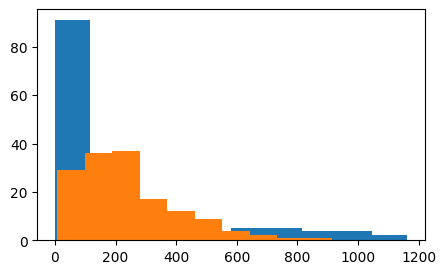

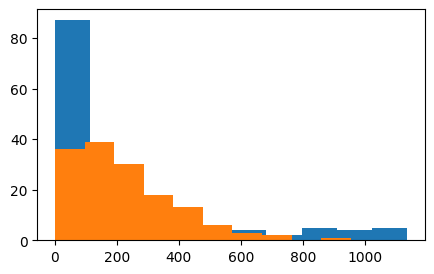

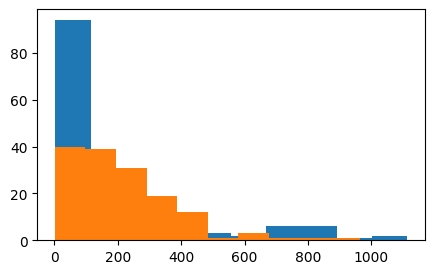

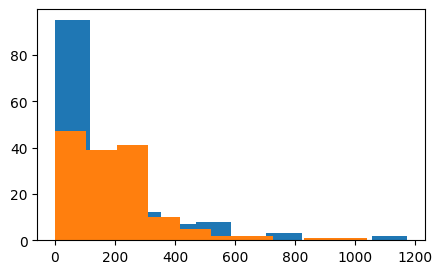

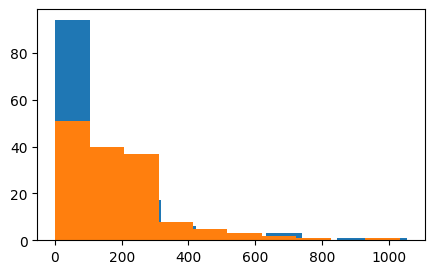

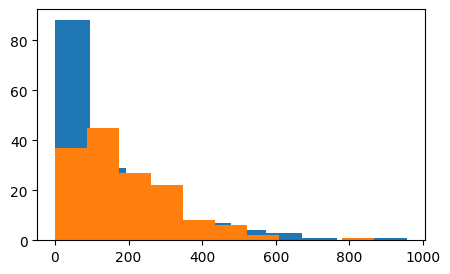

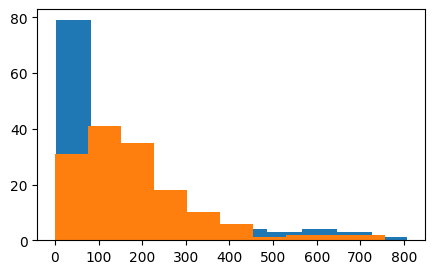

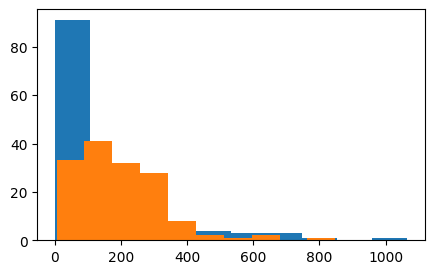

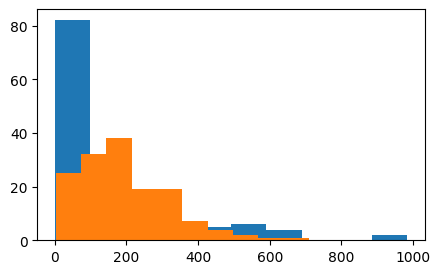

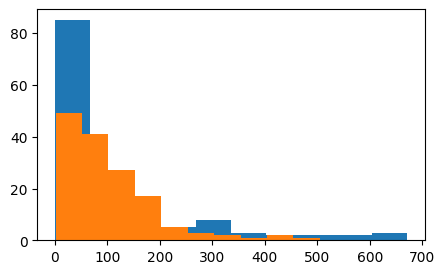

In [109]:
print(V_p_ts_.shape, W_p_ts_.shape)
print(Y_per_hat_p_ts_.shape, Y_cli_hat_p_ts_.shape, Y_cov_hat_p_ts_.shape)
print(y_ts_hat_LL_.shape, y_ts_hat_RR_.shape, y_ts_hat_ARD_.shape, y_ts_hat_BLR_.shape)


for i in range(N_hours):
    r_per_ = (V_p_ts_[:, i] - Y_per_hat_p_ts_[:, i])#**2
    r_cli_ = (V_p_ts_[:, i] - Y_cli_hat_p_ts_[:, i])**2
    r_cov_ = (V_p_ts_[:, i] - Y_cov_hat_p_ts_[:, i])**2
    
    r_ll_  = (V_p_ts_[:, i] - y_ts_hat_LL_[:, i])**2
    r_rr_  = (V_p_ts_[:, i] - y_ts_hat_RR_[:, i])**2
    r_ard_ = (V_p_ts_[:, i] - y_ts_hat_ARD_[:, i])**2
    r_blr_ = (V_p_ts_[:, i] - y_ts_hat_BLR_[:, i])#**2
    
    pr_per_ = np.absolute(r_per_)#/V_p_ts_[:, i]
    pr_cli_ = np.absolute(r_cli_)#/V_p_ts_[:, i]
    pr_cov_ = np.absolute(r_cov_)#/V_p_ts_[:, i]
    
    pr_ll_  = np.absolute(r_ll_)#/V_p_ts_[:, i]
    pr_rr_  = np.absolute(r_rr_)#/V_p_ts_[:, i]
    pr_ard_ = np.absolute(r_ard_)#/V_p_ts_[:, i]   
    pr_blr_ = np.absolute(r_blr_)#/V_p_ts_[:, i]   
    
    
    idx_per_ = np.argsort(pr_per_)
    idx_blr_ = np.argsort(pr_blr_)
    idx_ll_ = np.argsort(pr_ll_)

    
    plt.figure(figsize = (5, 3))
    #plt.hist(pr_ll_[idx_ll_])
    plt.hist(pr_per_[idx_per_])

    plt.hist(pr_blr_[idx_blr_])

    plt.show()

In [ ]:
# Defien data structure to train a global model
def _expert_model_structure(X_, Y_, Z_, i_expert):
    return X_[i_expert, :, :], Y_[i_expert, ], Z_[i_expert, :, :]


N_batch_samples = 100
r_cv = .75

N_batches = int(V_.shape[-1]/N_batch_samples)
print(N_batches)

Y_p_, V_p_, Z_p_ = _expert_model_structure(Y_, V_, Z_, 7)
print(Y_p_.shape, V_p_.shape, Z_p_.shape)

for i_batch in range(N_batches):
    j = i_batch*N_batch_samples
    k = (i_batch + 1)*N_batch_samples
    print(i_batch, j, k)
    
    # Compute Dataset samples in training and testing partition
    N_samples_tr = int(N_batch_samples*r_cv)
    N_samples_ts = N_sample_days - N_samples_tr
    print(N_samples_tr, N_samples_ts)
    
    V_p_tr_ = V_p_[:-N_samples_ts]
    V_p_ts_ = V_p_[-N_samples_ts:]
    print(V_p_tr_.shape, V_p_ts_.shape)

    Y_p_tr_ = Y_p_[:-N_samples_ts, :]
    Y_p_ts_ = Y_p_[-N_samples_ts:, :]
    print(Y_p_tr_.shape, Y_p_ts_.shape)

    Z_p_tr_ = Z_p_[:-N_samples_ts, [0, 3]]
    Z_p_ts_ = Z_p_[-N_samples_ts:, [0, 3]]
    print(Z_p_tr_.shape, Z_p_ts_.shape)

    Y_pp_tr_ = np.concatenate((Y_p_tr_, Z_p_tr_), axis = 1)
    Y_pp_ts_ = np.concatenate((Y_p_ts_, Z_p_ts_), axis = 1)
    print(Y_pp_tr_.shape, Y_pp_ts_.shape)

In [ ]:
def _expert_models(X_tr_, Y_tr_, X_ts_, Y_ts_):
    
    def __train_expert(X_, y_):
        # Define Standardizataion functions
        _X_scaler = StandardScaler().fit(X_)
        _y_scaler = StandardScaler().fit(y_[:, np.newaxis])
        # Standardize dataset
        X_p_ = _X_scaler.transform(X_)
        print(X_p_.shape, _X_scaler.mean_.shape)
        #X_p_ = X_.copy()
        y_p_ = _y_scaler.transform(y_[:, np.newaxis])[:, 0]
        #_LL = LassoLars(alpha = 10., max_iter = 100, normalize = False).fit(X_p_, y_p_)
        _LL = BayesianRidge(n_iter = 10, tol = 0.001).fit(X_p_, y_p_)
        return [_X_scaler, _y_scaler, _LL]
    
    
    def __test_expert(model_, X_):
        _X_scaler, _y_scaler, _ML = model_
        X_p_ = _X_scaler.transform(X_)
        #X_p_ = X_.copy()
        y_p_hat_ = _ML.predict(X_p_)
        return _y_scaler.inverse_transform(y_p_hat_[:, np.newaxis])[:, 0]
                                  
        
    N_tasks = Y_.shape[0]
    Y_ts_hat_ = np.zeros(Y_ts_.shape)
    for i_task in range(N_tasks):        
        model_ = __train_expert(X_tr_[i_task, ...], Y_tr_[i_task, ...])
        Y_ts_hat_[i_task, :] = __test_expert(model_, X_ts_[i_task, ...])
    return Y_ts_hat_

def _persistence(Y_):
    return Y_[:, :-1]

lag  = 4
